<a href="https://colab.research.google.com/github/UmarBalak/AdaptFL/blob/main/AdaptFL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main 1

In [ ]:
import requests
import h5py
import io

# Load HDF5 file from a URL
def load_hdf5_from_url(url, number_of_episodes=1):
    hdf5_files = []
    for episode_number in range(number_of_episodes):
      new_url = url + f'episode_{episode_number}.hdf5'
      response = requests.get(new_url)
      response.raise_for_status()  # Raise an error for bad responses
      hdf5_files.append(h5py.File(io.BytesIO(response.content), 'r'))
      print(f"episode_{episode_number}.hdf5 loaded successfully.")
    return hdf5_files

hdf5_url = 'https://huggingface.co/datasets/nightmare-nectarine/segmentation-carla-driving/resolve/main/train/'
hdf5_files = load_hdf5_from_url(hdf5_url, 6)


episode_0.hdf5 loaded successfully.
episode_1.hdf5 loaded successfully.
episode_2.hdf5 loaded successfully.
episode_3.hdf5 loaded successfully.
episode_4.hdf5 loaded successfully.
episode_5.hdf5 loaded successfully.


In [ ]:
# Explore the HDF5 file structure to see what datasets are present
def explore_hdf5_structure(hdf5_file):
    """
    Print the structure and contents of an HDF5 file to explore available datasets.
    """
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Type: {obj.dtype}")

    hdf5_file.visititems(print_structure)

# Check each episode file's structure
for episode_file in hdf5_files:
    print("Exploring HDF5 structure:")
    explore_hdf5_structure(episode_file)


Exploring HDF5 structure:
Dataset: controls, Shape: (1419, 3), Type: float64
Dataset: frame, Shape: (1419, 1), Type: int64
Dataset: hlc, Shape: (1419, 1), Type: int64
Dataset: light, Shape: (1419, 1), Type: int64
Dataset: measurements, Shape: (1419, 1), Type: float64
Dataset: rgb, Shape: (1419, 200, 288, 3), Type: uint8
Dataset: segmentation, Shape: (1419, 200, 288, 3), Type: uint8
Exploring HDF5 structure:
Dataset: controls, Shape: (1330, 3), Type: float64
Dataset: frame, Shape: (1330, 1), Type: int64
Dataset: hlc, Shape: (1330, 1), Type: int64
Dataset: light, Shape: (1330, 1), Type: int64
Dataset: measurements, Shape: (1330, 1), Type: float64
Dataset: rgb, Shape: (1330, 200, 288, 3), Type: uint8
Dataset: segmentation, Shape: (1330, 200, 288, 3), Type: uint8
Exploring HDF5 structure:
Dataset: controls, Shape: (2439, 3), Type: float64
Dataset: frame, Shape: (2439, 1), Type: int64
Dataset: hlc, Shape: (2439, 1), Type: int64
Dataset: light, Shape: (2439, 1), Type: int64
Dataset: measurem

In [ ]:
import numpy as np
import cv2

def preprocess_rgb_images(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing RGB images by normalizing and resizing them.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'rgb' dataset.
    - image_size: Target size for resizing the images.

    Returns:
    - rgb_images_combined: Combined and preprocessed RGB images from all episodes.
    """
    rgb_images_combined = []

    # Loop through each HDF5 file and process the RGB images
    for hdf5_file in hdf5_files:
        rgb_images = hdf5_file['rgb'][:]

        # Normalize RGB images
        rgb_images = rgb_images.astype(np.float32) / 255.0

        # Resize images
        rgb_images_resized = np.array([cv2.resize(img, image_size) for img in rgb_images])

        # Append to combined list
        rgb_images_combined.append(rgb_images_resized)

    # Concatenate all episodes into a single dataset
    rgb_images_combined = np.concatenate(rgb_images_combined, axis=0)

    return rgb_images_combined


def preprocess_segmentation_masks(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing segmentation masks by resizing them.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'segmentation' dataset.
    - image_size: Target size for resizing the masks.

    Returns:
    - segmentation_masks_combined: Combined and preprocessed segmentation masks from all episodes.
    """
    segmentation_masks_combined = []

    # Loop through each HDF5 file and process the segmentation masks
    for hdf5_file in hdf5_files:
        segmentation_masks = hdf5_file['segmentation'][:]

        # Resize masks
        segmentation_masks_resized = np.array([cv2.resize(mask, image_size) for mask in segmentation_masks])

        # Append to combined list
        segmentation_masks_combined.append(segmentation_masks_resized)

    # Concatenate all episodes into a single dataset
    segmentation_masks_combined = np.concatenate(segmentation_masks_combined, axis=0)

    return segmentation_masks_combined

import numpy as np

def preprocess_controls_multiple_episodes(hdf5_files):
    """
    Preprocess control data from multiple HDF5 files by concatenating and normalizing the controls.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'controls' dataset.

    Returns:
    - controls_normalized: Combined and normalized control data from all episodes.
    """
    controls_combined = []

    # Loop through each HDF5 file and concatenate the controls data
    for hdf5_file in hdf5_files:
        controls = hdf5_file['controls'][:]
        controls_combined.append(controls)

    # Concatenate all episodes' controls data
    controls_combined = np.concatenate(controls_combined, axis=0)

    # Normalize controls based on the max absolute value per feature
    controls_normalized = controls_combined / np.max(np.abs(controls_combined), axis=0)

    return controls_normalized

def preprocess_frames_multiple_episodes(hdf5_files):
    """
    Preprocess frame data from multiple HDF5 files by concatenating the frames.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'frame' dataset.

    Returns:
    - frames_combined: Combined frame data from all episodes.
    """
    frames_combined = []

    for hdf5_file in hdf5_files:
        frames = hdf5_file['frame'][:]
        frames_combined.append(frames)

    frames_combined = np.concatenate(frames_combined, axis=0)
    return frames_combined


def preprocess_hlc_multiple_episodes(hdf5_files):
    """
    Preprocess high-level command (hlc) data from multiple HDF5 files by concatenating the hlc data.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'hlc' dataset.

    Returns:
    - hlc_combined: Combined hlc data from all episodes.
    """
    hlc_combined = []

    for hdf5_file in hdf5_files:
        hlc = hdf5_file['hlc'][:]
        hlc_combined.append(hlc)

    hlc_combined = np.concatenate(hlc_combined, axis=0)
    return hlc_combined


def preprocess_light_multiple_episodes(hdf5_files):
    """
    Preprocess light data from multiple HDF5 files by concatenating the light data.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'light' dataset.

    Returns:
    - light_combined: Combined light data from all episodes.
    """
    light_combined = []

    for hdf5_file in hdf5_files:
        light = hdf5_file['light'][:]
        light_combined.append(light)

    light_combined = np.concatenate(light_combined, axis=0)
    return light_combined


def preprocess_measurements_multiple_episodes(hdf5_files):
    """
    Preprocess measurement data from multiple HDF5 files by concatenating the measurements.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'measurements' dataset.

    Returns:
    - measurements_combined: Combined measurement data from all episodes.
    """
    measurements_combined = []

    for hdf5_file in hdf5_files:
        measurements = hdf5_file['measurements'][:]
        measurements_combined.append(measurements)

    measurements_combined = np.concatenate(measurements_combined, axis=0)
    return measurements_combined


# Call the functions
rgb_data = preprocess_rgb_images(hdf5_files)
segmentation_data = preprocess_segmentation_masks(hdf5_files)
controls_normalized = preprocess_controls_multiple_episodes(hdf5_files)
frame_data = preprocess_frames_multiple_episodes(hdf5_files)
hlc_data = preprocess_hlc_multiple_episodes(hdf5_files)
light_data = preprocess_light_multiple_episodes(hdf5_files)
measurements_data = preprocess_measurements_multiple_episodes(hdf5_files)

# Output shapes for verification
print(f"RGB images shape: {rgb_data.shape}")
print(f"Segmentation masks shape: {segmentation_data.shape}")
print(f"Controls shape: {controls_normalized.shape}")
print(f"Frames shape: {frame_data.shape}")
print(f"HLC shape: {hlc_data.shape}")
print(f"Light shape: {light_data.shape}")
print(f"Measurements shape: {measurements_data.shape}")


RGB images shape: (9535, 128, 128, 3)
Segmentation masks shape: (9535, 128, 128, 3)
Controls shape: (9535, 3)
Frames shape: (9535, 1)
HLC shape: (9535, 1)
Light shape: (9535, 1)
Measurements shape: (9535, 1)


In [ ]:
def split_data_for_models_multiple_types(data_dict, num_models, data_distribution, data_types=None, random_seed=None):
    """
    Split the preprocessed data into subsets for local models based on the specified distribution.

    Parameters:
    - data_dict: Dictionary containing various preprocessed data types (X, y, etc.).
    - num_models: Number of local models to be implemented.
    - data_distribution: List of proportions for each model's training data.
    - data_types: List of data types to include in the split. If None, all data types are used.
    - random_seed: Seed for reproducibility of data splits.

    Returns:
    - model_data: Dictionary containing training data for each model.
    """

    # Validate inputs
    if len(data_distribution) != num_models:
        raise ValueError("Length of data_distribution must match num_models.")
    if not np.isclose(np.sum(data_distribution), 1.0):
        raise ValueError("Data distribution must sum to 1.")

    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    model_data = {}
    total_samples = len(data_dict['rgb'])  # Assumes all data types have the same length

    # If data_types is None, use all keys from data_dict
    if data_types is None:
        data_types = data_dict.keys()

    # Validate that all data types have the same number of samples
    for key in data_types:
        if key in data_dict and len(data_dict[key]) != total_samples:
            raise ValueError(f"Data type '{key}' has inconsistent sample size.")

    indices = np.arange(total_samples)
    np.random.shuffle(indices)  # Shuffle indices for randomness

    start_idx = 0
    for model_id in range(num_models):
        # Calculate the number of samples for the current model
        num_samples = int(data_distribution[model_id] * total_samples)
        if model_id == num_models - 1:  # Last model gets any leftover data
            num_samples = total_samples - start_idx

        model_data[f'model_{model_id + 1}'] = {
            key: np.array([data_dict[key][i] for i in indices[start_idx:start_idx + num_samples]])
            for key in data_types if key in data_dict
        }

        start_idx += num_samples

    return model_data

In [ ]:
data_dict = {
    'controls': controls_normalized,
    'frame': frame_data,
    'hlc': hlc_data,
    'light': light_data,
    'measurements': measurements_data,
    'rgb': rgb_data,
    'segmentation': segmentation_data,
}

# Specify the number of local models, data distribution, and types to include
num_local_models = 3
data_distribution = [0.4, 0.4, 0.2]
data_types_to_include = ['rgb', 'segmentation', 'hlc', 'light', 'measurements', 'controls', 'frame']

# Split the data for selected types
model_data = split_data_for_models_multiple_types(data_dict, num_local_models, data_distribution, data_types=data_types_to_include, random_seed=42)

# Output shapes for verification
for model_id, data in model_data.items():
    print(f"{model_id} - Data shapes:")
    for key, value in data.items():
        print(f"  {key}: {value.shape}")

model_1 - Data shapes:
  rgb: (3814, 128, 128, 3)
  segmentation: (3814, 128, 128, 3)
  hlc: (3814, 1)
  light: (3814, 1)
  measurements: (3814, 1)
  controls: (3814, 3)
  frame: (3814, 1)
model_2 - Data shapes:
  rgb: (3814, 128, 128, 3)
  segmentation: (3814, 128, 128, 3)
  hlc: (3814, 1)
  light: (3814, 1)
  measurements: (3814, 1)
  controls: (3814, 3)
  frame: (3814, 1)
model_3 - Data shapes:
  rgb: (1907, 128, 128, 3)
  segmentation: (1907, 128, 128, 3)
  hlc: (1907, 1)
  light: (1907, 1)
  measurements: (1907, 1)
  controls: (1907, 3)
  frame: (1907, 1)


In [ ]:
import tensorflow as tf
import keras
from keras import layers, Model, Input

# Defining the model architecture
def create_model(input_shapes):
    """
    Create a multi-input model based on the shapes of the input data.

    Parameters:
    - input_shapes: Dictionary containing the shape of each input type (e.g., 'rgb', 'segmentation', etc.)

    Returns:
    - A compiled Keras model with multiple inputs.
    """
    # Input layers for each type of data
    rgb_input = Input(shape=input_shapes['rgb'], name='rgb_input')
    seg_input = Input(shape=input_shapes['segmentation'], name='seg_input')
    hlc_input = Input(shape=input_shapes['hlc'], name='hlc_input')
    light_input = Input(shape=input_shapes['light'], name='light_input')
    measurements_input = Input(shape=input_shapes['measurements'], name='measurements_input')

    # Simple CNN for RGB and Segmentation inputs
    rgb_features = layers.Conv2D(32, (3, 3), activation='relu')(rgb_input)
    rgb_features = layers.MaxPooling2D((2, 2))(rgb_features)
    rgb_features = layers.Flatten()(rgb_features)

    seg_features = layers.Conv2D(32, (3, 3), activation='relu')(seg_input)
    seg_features = layers.MaxPooling2D((2, 2))(seg_features)
    seg_features = layers.Flatten()(seg_features)

    # Dense layers for other inputs
    hlc_features = layers.Dense(16, activation='relu')(hlc_input)
    light_features = layers.Dense(16, activation='relu')(light_input)
    measurements_features = layers.Dense(16, activation='relu')(measurements_input)

    # Concatenate all features
    concatenated = layers.concatenate([rgb_features, seg_features, hlc_features, light_features, measurements_features])

    # Output layer (adjust depending on your task, e.g., classification, regression)
    output = layers.Dense(1, activation='sigmoid')(concatenated)

    # Create model
    model = Model(inputs=[rgb_input, seg_input, hlc_input, light_input, measurements_input], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

In [ ]:
local_models = []
for model_id, data in model_data.items():
    print(f"Training {model_id}...")

    # Get the shapes of the inputs
    input_shapes = {key: data[key].shape[1:] for key in data_types_to_include}

    # Create a model for this data
    model = create_model(input_shapes)

    labels = data['controls']

    model.fit(
        [data['rgb'], data['segmentation'], data['hlc'], data['light'], data['measurements']],
        labels, epochs=3, batch_size=16
    )

    local_models.append(model)
    print(f"{model_id} training complete.\n")

Training model_1...
Epoch 1/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 72s 291ms/step - loss: 0.7091 - mae: 0.7294
Epoch 2/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 68s 285ms/step - loss: 0.7073 - mae: 0.7278
Epoch 3/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 83s 289ms/step - loss: 0.7089 - mae: 0.7301
model_1 training complete.

Training model_2...
Epoch 1/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - loss: 0.2627 - mae: 0.2895
Epoch 2/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 85s 303ms/step - loss: 0.2490 - mae: 0.2768
Epoch 3/3
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 337ms/step - loss: 0.2482 - mae: 0.2765
model_2 training complete.

Training model_3...
Epoch 1/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 292ms/step - loss: 0.2511 - mae: 0.2812
Epoch 2/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - loss: 0.2425 - mae: 0.2713
Epoch 3/3
120/120 ━━━━━━━━━━━━━━━━━━━━ 35s 288ms/step - loss: 0.2421 - mae: 0.2704
model_3 training complete.



In [ ]:
for id, model in enumerate(local_models):
    filepath = f"local_model_{id}_weights.weights.h5"
    model.save_weights(filepath)
    print(f"{id} training complete and weights saved as {filepath}.\n")

    print(f"\nWeights for {model_id}:")
    for layer in model.layers:
        print(f"Layer: {layer.name}, Weights: {layer.get_weights()}")

0 training complete and weights saved as local_model_0_weights.weights.h5.


Weights for model_3:
Layer: rgb_input, Weights: []
Layer: seg_input, Weights: []
Layer: conv2d, Weights: [array([[[[-3.76679674e-02, -1.37819096e-01, -3.66446972e-02,
          -1.12351343e-01,  1.35005906e-01,  6.24981970e-02,
          -9.33061913e-02,  5.15570641e-02,  1.31174102e-01,
           4.62064147e-03, -1.15149736e-01, -4.36009467e-03,
          -5.62052429e-03, -2.06013545e-02, -9.32455808e-02,
           4.69710380e-02,  7.57818073e-02, -1.07630804e-01,
           9.32545364e-02,  3.65894735e-02,  5.97517639e-02,
          -8.72569531e-02, -3.27192098e-02,  2.20156759e-02,
          -8.00999105e-02,  1.23308793e-01,  5.63604087e-02,
          -5.35565913e-02, -1.32620722e-01,  5.41906953e-02,
          -1.47592276e-02,  2.31804103e-02],
         [ 8.99617374e-02, -9.18469876e-02,  5.83085865e-02,
           9.45867896e-02, -2.22826004e-02,  1.00148335e-01,
           9.77399200e-02,  5.82842976e-

In [ ]:
# Step 1: Initialize the global model (same architecture as local models)
global_model = create_model(input_shapes)  # Make sure to use the same input shapes as the local models

# Step 2: Extract weights from local models
local_weights = [model.get_weights() for model in local_models]

# Step 3: Aggregate the weights (simple averaging of the local model weights)
# Initialize averaged weights with the same shape as the local model weights
average_weights = [np.zeros_like(w) for w in local_weights[0]]

# Sum the weights from all local models
for weights in local_weights:
    for i, weight in enumerate(weights):
        average_weights[i] += weight

# Divide by the number of local models to get the average
average_weights = [weight / len(local_weights) for weight in average_weights]

# Step 4: Set the averaged weights in the global model
global_model.set_weights(average_weights)

# Step 5: Save the global model weights (optional)
global_model.save_weights("global_model_weights.weights.h5")
print("Global model weights updated and saved.")

print(f"\nGlobal model weights:")
for layer in global_model.layers:
    print(f"Layer: {layer.name}, Weights: {layer.get_weights()}")



Global model weights updated and saved.

Global model weights:
Layer: rgb_input, Weights: []
Layer: seg_input, Weights: []
Layer: conv2d_14, Weights: [array([[[[ 2.85070986e-02, -6.42569065e-02,  4.42108624e-02,
          -8.79317001e-02,  4.58396738e-03,  7.59787261e-02,
          -9.86956805e-03,  5.31485379e-02,  1.03464566e-01,
          -4.40387689e-02, -4.70739715e-02, -2.60553304e-02,
          -4.23545726e-02,  1.35294227e-02, -2.48859245e-02,
          -3.52326520e-02, -2.07012407e-02,  2.92606354e-02,
           6.55689240e-02,  6.48701787e-02, -2.40414869e-02,
          -6.75410852e-02,  2.28687692e-02, -5.57964742e-02,
           1.34547623e-02,  8.25324878e-02,  7.55227217e-03,
          -2.78653651e-02, -9.74363089e-02,  4.33299653e-02,
           2.97086313e-03, -7.34136775e-02],
         [ 6.52208254e-02, -4.67622392e-02,  6.47058338e-02,
           3.44694033e-02, -5.90280108e-02,  4.50206697e-02,
           2.43729651e-02,  6.94619194e-02, -3.39843072e-02,
           

# Testing

In [ ]:
import requests
from bs4 import BeautifulSoup
import h5py
from io import BytesIO
import numpy as np
import random
import matplotlib.pyplot as plt

# Base URL where the HDF5 files are located
base_url = 'https://huggingface.co/datasets/nightmare-nectarine/segmentation-carla-driving/tree/main/train/'

# Function to scrape all HDF5 file links from the given page
def get_file_urls(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    file_urls = []
    for link in soup.find_all('a'):
        href = link.get('href')
        # Check for links ending with .hdf5 and containing '/blob/' in URL
        if '/blob/' in href and href.endswith('.hdf5'):
            # Construct full file URL (replace 'blob/' with 'resolve/' for direct access)
            file_url = 'https://huggingface.co' + href.replace('/blob/', '/resolve/')
            file_urls.append(file_url)  # Append modified URL
    return file_urls

# List to store tuples of (HLC value, RGB image)
hlc_rgb_data = []

# Get all file URLs from the page
file_urls = get_file_urls(base_url)

num_files_to_pick = 5
if num_files_to_pick > len(file_urls):
    print(f"Requested {num_files_to_pick} files, but only {len(file_urls)} are available.")
    num_files_to_pick = len(file_urls)

# Randomly select files
random_files = random.sample(file_urls, num_files_to_pick)

for url in random_files:
    # Download the file
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Validate if the content is in HDF5 format
        try:
            with h5py.File(BytesIO(response.content), 'r') as f:
                # Access the datasets
                hlc_data = f['hlc'][:]
                rgb_data = f['rgb'][:]  # Assuming 'rgb' contains the images

                # Store HLC and corresponding RGB images in the list
                for i in range(len(hlc_data)):
                    hlc_value = hlc_data[i].item()  # Convert numpy int to Python int
                    rgb_image = rgb_data[i]
                    hlc_rgb_data.append((hlc_value, rgb_image))  # Append as a tuple

        except Exception as e:
            print(f"Error processing {url}: {e}")
    else:
        print(f"Failed to download {url}: {response.status_code}")



Displaying 20 images for the specified HLC values.


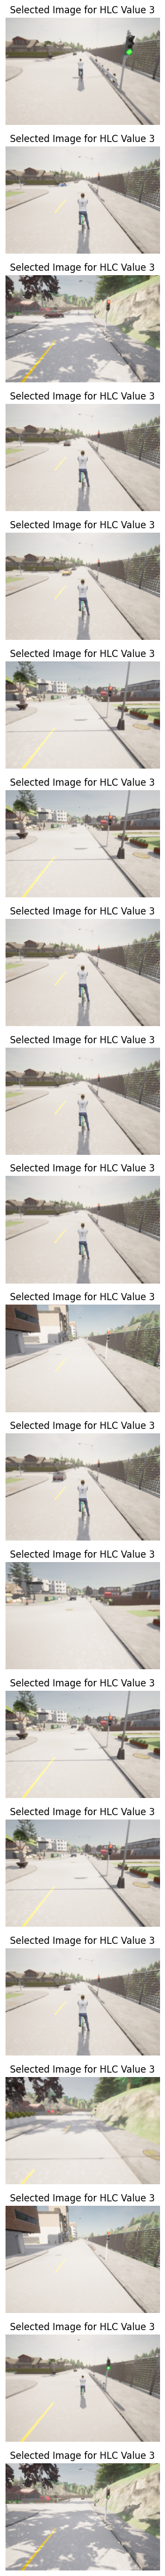

In [ ]:
# Specify the HLC values you are interested in
desired_hlc_values = [3]

# Randomly select up to 5 images for the specified HLC values
selected_images = []
selected_hlc_values = []  # To keep track of which HLC values correspond to selected images

for hlc in desired_hlc_values:
    images = [img for value, img in hlc_rgb_data if value == hlc]

    if images:
        # Randomly select up to 5 images for the current HLC value
        sampled_images = random.sample(images, min(20, len(images)))
        selected_images.extend(sampled_images)
        selected_hlc_values.extend([hlc] * len(sampled_images))  # Append the HLC value for each selected image

# Display selected images (up to 5)
if selected_images:
    print(f"Displaying {len(selected_images)} images for the specified HLC values.")
    plt.figure(figsize=(15, len(selected_images) * 3))
    for idx, (image, hlc) in enumerate(zip(selected_images, selected_hlc_values)):
        plt.subplot(len(selected_images), 1, idx + 1)
        plt.imshow(image)
        plt.title(f"Selected Image for HLC Value {hlc}")
        plt.axis('off')
    plt.show()
else:
    print("No images found for the specified HLC values.")

# Main 2

In [6]:
import requests
import h5py
import io

# Load HDF5 file from a URL
import requests
import h5py
import io

def load_hdf5_from_url(url, episode_numbers):
    """
    Load specified HDF5 episodes from the given URL.

    Parameters:
    - url: The base URL where the HDF5 files are hosted.
    - episode_numbers: List of episode numbers to load.

    Returns:
    - hdf5_files: A list of loaded HDF5 file objects.
    """
    hdf5_files = []
    for episode_number in episode_numbers:
        new_url = url + f'episode_{episode_number}.hdf5'
        response = requests.get(new_url)
        response.raise_for_status()  # Raise an error for bad responses
        hdf5_files.append(h5py.File(io.BytesIO(response.content), 'r'))
        print(f"episode_{episode_number}.hdf5 loaded successfully.")

    return hdf5_files

# Example usage
hdf5_url = 'https://huggingface.co/datasets/nightmare-nectarine/segmentation-carla-driving/resolve/main/train/'
episode_numbers = [0, 2, 4]  # User-specified episode numbers
hdf5_files = load_hdf5_from_url(hdf5_url, episode_numbers)


import h5py
import os
import random

def load_random_hdf5_from_folder(folder_path, number_of_episodes=1):
    # Get all .hdf5 files in the folder
    available_files = [f for f in os.listdir(folder_path) if f.endswith('.hdf5')]

    # If there are fewer available files than requested, load all
    if len(available_files) < number_of_episodes:
        print(f"Only {len(available_files)} files found. Loading all available files.")
        selected_files = available_files
    else:
        # Randomly select the specified number of episodes
        selected_files = random.sample(available_files, number_of_episodes)

    hdf5_files = []
    for file_name in selected_files:
        file_path = os.path.join(folder_path, file_name)
        hdf5_files.append(h5py.File(file_path, 'r'))
        print(f"{file_name} loaded successfully.")

    return hdf5_files

# folder_path = 'E:\Major-Project\Dataset'
# hdf5_files = load_random_hdf5_from_folder(folder_path, 14)


# Explore the HDF5 file structure to see what datasets are present
def explore_hdf5_structure(hdf5_file):
    """
    Print the structure and contents of an HDF5 file to explore available datasets.
    """
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Type: {obj.dtype}")

    hdf5_file.visititems(print_structure)

# Check each episode file's structure
# for episode_file in hdf5_files:
#     print("Exploring HDF5 structure:")
#     explore_hdf5_structure(episode_file)


import numpy as np
import cv2

def preprocess_rgb_images(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing RGB images by normalizing and resizing them.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'rgb' dataset.
    - image_size: Target size for resizing the images.

    Returns:
    - rgb_images_combined: Combined and preprocessed RGB images from all episodes.
    """
    rgb_images_combined = []

    # Loop through each HDF5 file and process the RGB images
    for hdf5_file in hdf5_files:
        rgb_images = hdf5_file['rgb'][:]

        # Normalize RGB images
        rgb_images = rgb_images.astype(np.float32) / 255.0

        # Resize images
        rgb_images_resized = np.array([cv2.resize(img, image_size) for img in rgb_images])

        # Append to combined list
        rgb_images_combined.append(rgb_images_resized)

    # Concatenate all episodes into a single dataset
    rgb_images_combined = np.concatenate(rgb_images_combined, axis=0)

    return rgb_images_combined


def preprocess_segmentation_masks(hdf5_files, image_size=(128, 128)):
    """
    Preprocess multiple HDF5 files containing segmentation masks by resizing them.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'segmentation' dataset.
    - image_size: Target size for resizing the masks.

    Returns:
    - segmentation_masks_combined: Combined and preprocessed segmentation masks from all episodes.
    """
    segmentation_masks_combined = []

    # Loop through each HDF5 file and process the segmentation masks
    for hdf5_file in hdf5_files:
        segmentation_masks = hdf5_file['segmentation'][:]

        # Resize masks
        segmentation_masks_resized = np.array([cv2.resize(mask, image_size) for mask in segmentation_masks])

        # Append to combined list
        segmentation_masks_combined.append(segmentation_masks_resized)

    # Concatenate all episodes into a single dataset
    segmentation_masks_combined = np.concatenate(segmentation_masks_combined, axis=0)

    return segmentation_masks_combined

import numpy as np

def preprocess_controls_multiple_episodes(hdf5_files):
    """
    Preprocess control data from multiple HDF5 files by concatenating and normalizing the controls.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'controls' dataset.

    Returns:
    - controls_normalized: Combined and normalized control data from all episodes.
    """
    controls_combined = []

    # Loop through each HDF5 file and concatenate the controls data
    for hdf5_file in hdf5_files:
        controls = hdf5_file['controls'][:]
        controls_combined.append(controls)

    # Concatenate all episodes' controls data
    controls_combined = np.concatenate(controls_combined, axis=0)

    # Normalize controls based on the max absolute value per feature
    controls_normalized = controls_combined / np.max(np.abs(controls_combined), axis=0)

    return controls_normalized

def preprocess_frames_multiple_episodes(hdf5_files):
    """
    Preprocess frame data from multiple HDF5 files by concatenating the frames.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'frame' dataset.

    Returns:
    - frames_combined: Combined frame data from all episodes.
    """
    frames_combined = []

    for hdf5_file in hdf5_files:
        frames = hdf5_file['frame'][:]
        frames_combined.append(frames)

    frames_combined = np.concatenate(frames_combined, axis=0)
    return frames_combined


def preprocess_hlc_multiple_episodes(hdf5_files):
    """
    Preprocess high-level command (hlc) data from multiple HDF5 files by concatenating the hlc data.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'hlc' dataset.

    Returns:
    - hlc_combined: Combined hlc data from all episodes.
    """
    hlc_combined = []

    for hdf5_file in hdf5_files:
        hlc = hdf5_file['hlc'][:]
        hlc_combined.append(hlc)

    hlc_combined = np.concatenate(hlc_combined, axis=0)
    return hlc_combined


def preprocess_light_multiple_episodes(hdf5_files):
    """
    Preprocess light data from multiple HDF5 files by concatenating the light data.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'light' dataset.

    Returns:
    - light_combined: Combined light data from all episodes.
    """
    light_combined = []

    for hdf5_file in hdf5_files:
        light = hdf5_file['light'][:]
        light_combined.append(light)

    light_combined = np.concatenate(light_combined, axis=0)
    return light_combined


def preprocess_measurements_multiple_episodes(hdf5_files):
    """
    Preprocess measurement data from multiple HDF5 files by concatenating the measurements.

    Parameters:
    - hdf5_files: List of HDF5 files containing the 'measurements' dataset.

    Returns:
    - measurements_combined: Combined measurement data from all episodes.
    """
    measurements_combined = []

    for hdf5_file in hdf5_files:
        measurements = hdf5_file['measurements'][:]
        measurements_combined.append(measurements)

    measurements_combined = np.concatenate(measurements_combined, axis=0)
    return measurements_combined


# Call the functions
rgb_data = preprocess_rgb_images(hdf5_files)
segmentation_data = preprocess_segmentation_masks(hdf5_files)
controls_normalized = preprocess_controls_multiple_episodes(hdf5_files)
frame_data = preprocess_frames_multiple_episodes(hdf5_files)
hlc_data = preprocess_hlc_multiple_episodes(hdf5_files)
light_data = preprocess_light_multiple_episodes(hdf5_files)
measurements_data = preprocess_measurements_multiple_episodes(hdf5_files)

# Output shapes for verification
print(f"RGB images shape: {rgb_data.shape}")
print(f"Segmentation masks shape: {segmentation_data.shape}")
print(f"Controls shape: {controls_normalized.shape}")
print(f"Frames shape: {frame_data.shape}")
print(f"HLC shape: {hlc_data.shape}")
print(f"Light shape: {light_data.shape}")
print(f"Measurements shape: {measurements_data.shape}")



episode_0.hdf5 loaded successfully.
episode_1.hdf5 loaded successfully.
episode_2.hdf5 loaded successfully.
episode_3.hdf5 loaded successfully.
episode_4.hdf5 loaded successfully.
RGB images shape: (7774, 128, 128, 3)
Segmentation masks shape: (7774, 128, 128, 3)
Controls shape: (7774, 3)
Frames shape: (7774, 1)
HLC shape: (7774, 1)
Light shape: (7774, 1)
Measurements shape: (7774, 1)


In [7]:
import h5py

# Saving data
with h5py.File('preprocessed_data_e0_e4.h5', 'w') as f:
    f.create_dataset('rgb', data=rgb_data)
    f.create_dataset('segmentation', data=segmentation_data)
    f.create_dataset('controls', data=controls_normalized)
    f.create_dataset('hlc', data=hlc_data)
    f.create_dataset('light', data=light_data)
    f.create_dataset('measurements', data=measurements_data)

# Loading data
with h5py.File('preprocessed_data_e0_e4.h5', 'r') as f:
    rgb_data = f['rgb'][:]
    segmentation_data = f['segmentation'][:]
    controls_normalized = f['controls'][:]
    hlc_data = f['hlc'][:]
    light_data = f['light'][:]
    measurements_data = f['measurements'][:]


In [8]:
def split_data_for_models_multiple_types(data_dict, num_models, data_distribution, val_split=0.2, test_split=0.1, data_types=None, random_seed=None):
    """
    Split the preprocessed data into subsets for local models, validation set, and test set.

    Parameters:
    - data_dict: Dictionary containing various preprocessed data types (X, y, etc.).
    - num_models: Number of local models to be implemented.
    - data_distribution: List of proportions for each model's training data.
    - val_split: Proportion of data to be used for validation.
    - test_split: Proportion of data to be used for testing.
    - data_types: List of data types to include in the split. If None, all data types are used.
    - random_seed: Seed for reproducibility of data splits.

    Returns:
    - model_data: Dictionary containing training data for each model.
    - val_data: Dictionary containing validation data.
    - test_data: Dictionary containing test data.
    """

    # Validate inputs
    if len(data_distribution) != num_models:
        raise ValueError("Length of data_distribution must match num_models.")
    if not np.isclose(np.sum(data_distribution), 1.0):
        raise ValueError("Data distribution must sum to 1.")

    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    total_samples = len(data_dict['rgb'])  # Assumes all data types have the same length

    # Split indices into training, validation, and test sets
    indices = np.arange(total_samples)
    np.random.shuffle(indices)  # Shuffle indices for randomness

    # Calculate the number of samples for validation and test
    val_size = int(total_samples * val_split)
    test_size = int(total_samples * test_split)

    val_indices = indices[:val_size]
    test_indices = indices[val_size:val_size + test_size]
    train_indices = indices[val_size + test_size:]

    # Prepare validation and test data
    val_data = {
        key: np.array([data_dict[key][i] for i in val_indices])
        for key in (data_types or data_dict.keys()) if key in data_dict
    }

    test_data = {
        key: np.array([data_dict[key][i] for i in test_indices])
        for key in (data_types or data_dict.keys()) if key in data_dict
    }

    # Prepare model data for training
    model_data = {}
    total_train_samples = len(train_indices)

    start_idx = 0
    for model_id in range(num_models):
        # Calculate the number of samples for the current model
        num_samples = int(data_distribution[model_id] * total_train_samples)
        if model_id == num_models - 1:  # Last model gets any leftover data
            num_samples = total_train_samples - start_idx

        model_data[f'model_{model_id + 1}'] = {
            key: np.array([data_dict[key][train_indices[i]] for i in range(start_idx, start_idx + num_samples)])
            for key in (data_types or data_dict.keys()) if key in data_dict
        }

        start_idx += num_samples

    return model_data, val_data, test_data



data_dict = {
    'controls': controls_normalized,
    'frame': frame_data,
    'hlc': hlc_data,
    'light': light_data,
    'measurements': measurements_data,
    'rgb': rgb_data,
    'segmentation': segmentation_data,
}

In [9]:
# Specify the number of local models, data distribution, and types to include
num_local_models = 2
data_distribution = [0.9, 0.1]
data_types_to_include = ['rgb', 'segmentation', 'hlc', 'light', 'measurements', 'controls', 'frame']

# Split the data for selected types
model_data, val_data, test_data = split_data_for_models_multiple_types(data_dict, num_local_models, data_distribution=data_distribution)

# model_data = split_data_for_models_multiple_types(data_dict, num_local_models, data_distribution, data_types=data_types_to_include, random_seed=42)

# Output shapes for verification
for model_id, data in model_data.items():
    print(f"{model_id} - Data shapes:")
    for key, value in data.items():
        print(f"  {key}: {value.shape}")


model_1 - Data shapes:
  controls: (4898, 3)
  frame: (4898, 1)
  hlc: (4898, 1)
  light: (4898, 1)
  measurements: (4898, 1)
  rgb: (4898, 128, 128, 3)
  segmentation: (4898, 128, 128, 3)
model_2 - Data shapes:
  controls: (545, 3)
  frame: (545, 1)
  hlc: (545, 1)
  light: (545, 1)
  measurements: (545, 1)
  rgb: (545, 128, 128, 3)
  segmentation: (545, 128, 128, 3)


In [10]:


import tensorflow as tf
import keras
from keras import layers, Model, Input


from keras import layers, Model
from keras.layers import Input
from keras.applications import VGG16  # Example for using a pre-trained model
from keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D

def create_model(input_shapes):
    """
    Create a more accurate multi-input model based on the shapes of the input data.

    Parameters:
    - input_shapes: Dictionary containing the shape of each input type (e.g., 'rgb', 'segmentation', etc.)

    Returns:
    - A compiled Keras model with multiple inputs for multi-class classification.
    """
    # Input layers for each type of data
    rgb_input = Input(shape=input_shapes['rgb'], name='rgb_input')
    seg_input = Input(shape=input_shapes['segmentation'], name='seg_input')
    controls_input = Input(shape=input_shapes['controls'], name='controls_input')
    light_input = Input(shape=input_shapes['light'], name='light_input')
    measurements_input = Input(shape=input_shapes['measurements'], name='measurements_input')

    # Using a pre-trained model for RGB input
    base_model_rgb = VGG16(weights='imagenet', include_top=False, input_tensor=rgb_input)
    rgb_features = base_model_rgb.output
    rgb_features = GlobalAveragePooling2D()(rgb_features)
    rgb_features = Dropout(0.5)(rgb_features)  # Adding Dropout

    # CNN for Segmentation input
    seg_features = layers.Conv2D(32, (3, 3), activation='relu')(seg_input)
    seg_features = layers.MaxPooling2D((2, 2))(seg_features)
    seg_features = layers.Conv2D(64, (3, 3), activation='relu')(seg_features)
    seg_features = layers.MaxPooling2D((2, 2))(seg_features)
    seg_features = layers.Flatten()(seg_features)
    seg_features = Dropout(0.5)(seg_features)  # Adding Dropout

    # Dense layers for other inputs with Batch Normalization
    controls_features = layers.Dense(32, activation='relu')(controls_input)
    controls_features = BatchNormalization()(controls_features)
    light_features = layers.Dense(32, activation='relu')(light_input)
    light_features = BatchNormalization()(light_features)
    measurements_features = layers.Dense(32, activation='relu')(measurements_input)
    measurements_features = BatchNormalization()(measurements_features)

    # Concatenate all features
    concatenated = layers.concatenate([rgb_features, seg_features, controls_features, light_features, measurements_features])

    # Output layer (adjust depending on your task, e.g., classification, regression)
    output = layers.Dense(4, activation='softmax')(concatenated)

    # Create model
    model = Model(inputs=[rgb_input, seg_input, controls_input, light_input, measurements_input], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



# for model_id, data in model_data.items():
#     print(f"Training {model_id}...")

#     # Get the shapes of the inputs
#     input_shapes = {key: data[key].shape[1:] for key in data_types_to_include}

#     # Create a model for this data
#     model = create_model(input_shapes)

#     labels = data['hlc']

#     model.fit(
#         [data['rgb'], data['segmentation'], data['controls'], data['light'], data['measurements']],
#         labels, epochs=3, batch_size=32,
#         validation_data=(
#                 [val_data['rgb'], val_data['segmentation'], val_data['controls'], val_data['light'], val_data['measurements']],
#                 val_data['hlc']
#             ),
#     )

#     local_models.append(model)
#     print(f"{model_id} training complete.\n")

# for id, model in enumerate(local_models):
#     filepath = f"local_model_{id}_weights.weights.h5"
#     model.save_weights(filepath)
#     print(f"{id} training complete and weights saved as {filepath}.\n")

#     print(f"\nWeights for {model_id}:")
#     for layer in model.layers:
#         print(f"Layer: {layer.name}, Weights: {layer.get_weights()}")



In [11]:
local_models = []

In [12]:

# Get the shapes of the inputs
data = model_data['model_1']
input_shapes = {key: data[key].shape[1:] for key in data_types_to_include}

# Create a model for this data
model = create_model(input_shapes)

labels = data['hlc']

model.fit(
    [data['rgb'], data['segmentation'], data['controls'], data['light'], data['measurements']],
    labels, epochs=3, batch_size=32,
    validation_data=(
            [val_data['rgb'], val_data['segmentation'], val_data['controls'], val_data['light'], val_data['measurements']],
            val_data['hlc']
        ),
)

local_models.append(model)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 346ms/step - accuracy: 0.7746 - loss: 40.3400 - val_accuracy: 0.9755 - val_loss: 0.0750
Epoch 2/3
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - accuracy: 0.9765 - loss: 0.0636 - val_accuracy: 0.9839 - val_loss: 0.0436
Epoch 3/3
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.9854 - loss: 0.0498 - val_accuracy: 0.9923 - val_loss: 0.0239


In [13]:
# Get the shapes of the inputs
data = model_data['model_2']
input_shapes = {key: data[key].shape[1:] for key in data_types_to_include}

# Create a model for this data
model = create_model(input_shapes)

labels = data['hlc']

model.fit(
    [data['rgb'], data['segmentation'], data['controls'], data['light'], data['measurements']],
    labels, epochs=3, batch_size=32,
    validation_data=(
            [val_data['rgb'], val_data['segmentation'], val_data['controls'], val_data['light'], val_data['measurements']],
            val_data['hlc']
        ),
)

local_models.append(model)

Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2813 - loss: 371.0951 - val_accuracy: 0.8398 - val_loss: 1.1104
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 327ms/step - accuracy: 0.8859 - loss: 0.9226 - val_accuracy: 0.8983 - val_loss: 0.3923
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.9057 - loss: 0.4320 - val_accuracy: 0.8958 - val_loss: 0.3127


In [ ]:
# Get the shapes of the inputs
data = model_data['model_3']
input_shapes = {key: data[key].shape[1:] for key in data_types_to_include}

# Create a model for this data
model = create_model(input_shapes)

labels = data['hlc']

model.fit(
    [data['rgb'], data['segmentation'], data['controls'], data['light'], data['measurements']],
    labels, epochs=3, batch_size=32,
    validation_data=(
            [val_data['rgb'], val_data['segmentation'], val_data['controls'], val_data['light'], val_data['measurements']],
            val_data['hlc']
        ),
)

local_models.append(model)

Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3595 - loss: 178.7458 - val_accuracy: 0.8288 - val_loss: 4.2165
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step - accuracy: 0.8765 - loss: 1.9066 - val_accuracy: 0.9260 - val_loss: 0.2928
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.9654 - loss: 0.1350 - val_accuracy: 0.9292 - val_loss: 0.2365


## Upload Weights

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
# Path to save the weights in Google Drive
save_path = '/content/drive/My Drive/model_weights/model_1_weights.weights.h5'

# Save the model's weights
local_models[0].save_weights(save_path)


In [17]:
import numpy as np

# 1. Save the original model's weights
original_weights_model_1 = local_models[0].get_weights()

# 2. Load the weights into a new instance of the model
uploaded_weights_model_1 = create_model(input_shapes)
uploaded_weights_model_1.load_weights(save_path)

# 3. Get the weights of the new model
loaded_weights_of_uploaded_weights_model_1 = uploaded_weights_model_1.get_weights()

# 4. Compare the weights
weights_are_equal = all([np.array_equal(ow, lw) for ow, lw in zip(original_weights_model_1, loaded_weights_of_uploaded_weights_model_1)])

if weights_are_equal:
    print("Weights are the same!")
else:
    print("Weights are different.")

Weights are the same!


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Testing

In [ ]:
test_inputs = [
        test_data['rgb'],
        test_data['segmentation'],
        test_data['controls'],
        test_data['light'],
        test_data['measurements']
    ]

# Get the true labels from the test data
true_labels = test_data['hlc']


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

for model_id, model in enumerate(local_models):
    # Predict on the test set
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)  # Assuming softmax output for multi-class classification

    # Calculate performance metrics
    accuracy = np.mean(predicted_labels == true_labels)
    print(f"Accuracy for {model_id + 1}: {accuracy:.4f}")

    # Generate a classification report and confusion matrix
    report = classification_report(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"Classification Report for {model_id + 1}:\n{report}")
    print(f"Confusion Matrix for {model_id + 1}:\n{cm}\n")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Accuracy for 1: 0.3063
Classification Report for 1:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       295
           1       0.98      0.97      0.98       126
           2       1.00      0.96      0.98        84
           3       0.99      0.99      0.99       272

    accuracy                           0.98       777
   macro avg       0.98      0.97      0.98       777
weighted avg       0.98      0.98      0.98       777

Confusion Matrix for 1:
[[289   2   0   4]
 [  4 122   0   0]
 [  3   0  81   0]
 [  4   0   0 268]]

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
Accuracy for 2: 0.3062
Classification Report for 2:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       295
           1       0.96      0.93      0.94       126
           2       0.96      0.95      0.96        84
           3       0.98      0.97      0.97       272

    acc